In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

import time
from sklearn.metrics import mean_squared_error

import seaborn as sns

In [32]:
# initializing a list to hold different model performance metrics
performance_metrics = []

Data Prep

In [33]:
# replace data with that given from homework
housing_df = pd.read_csv(
    "/Users/abbeylasater/Desktop/cs-6470/homework_1/housing_data.csv"
)
print(housing_df.head())

X = housing_df[["size", "bedrooms", "age"]].values
y = housing_df["price"].values

   size  bedrooms  age  price
0  1400         3   10    245
1  1600         3    8    312
2  1700         2   20    279
3  1875         4    5    308
4  1100         2   25    199


In [34]:
# scaling our x values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Base Class

In [35]:
class BaseLinearRegression:
    def __init__(self, fit_intercept):
        # Initialize coefficients (weights for features) as None
        self.coef_ = None
        # Initialize intercept (bias term) to 0
        self.intercept_ = 0.0
        # Whether to include an intercept in predictions
        self.fit_intercept = fit_intercept

    def fit(self, X, y):
        # Abstract method: each subclass implements its own fitting logic
        raise NotImplementedError("Subclasses should implement this")

    def predict(self, X):
        # Convert input to NumPy array for easier math operations
        X = np.array(X)

        # Ensure the model has been fitted; otherwise, predictions are invalid
        if self.coef_ is None:
            raise Exception(
                "Model is not fitted yet. Please call 'fit' before 'predict'."
            )

        # Compute predictions: y_pred = X * weights + intercept
        # NumPy dot product computes sum of (feature * weight) efficiently
        y_pred = X.dot(np.array(self.coef_))  # feature contributions

        # Add intercept if fit_intercept is True
        if self.fit_intercept:
            y_pred += self.intercept_

        # Return predictions as a Python list to maintain consistency with older code
        return y_pred.tolist()

    def score(self, X, y_true):
        # Convert input to NumPy arrays
        X = np.array(X)
        y_true = np.array(y_true)

        # Get predictions
        y_pred = np.array(self.predict(X))

        # Compute mean of actual y values
        y_mean = y_true.mean()

        # Compute sum of squares of residuals: sum((y_true - y_pred)^2)
        ss_res = ((y_true - y_pred) ** 2).sum()

        # Compute total sum of squares: sum((y_true - mean)^2)
        ss_tot = ((y_true - y_mean) ** 2).sum()

        # Compute R^2 score: proportion of variance explained
        # 1 is perfect fit, 0 means predicting mean, negative worse than mean
        return 1 - (ss_res / ss_tot)

Model - Linear Regression Using Gradient Descent

In [36]:
class GradientDescent(BaseLinearRegression):
    def __init__(
        self, fit_intercept, learning_rate, max_iter, random_state, batch_size
    ):
        # inherit from BaseLinearRegression
        super().__init__(fit_intercept)
        # learning rate = step size; how big each step is in gradient descent
        self.learning_rate = learning_rate
        # max iterations = number of epochs; how many times to loop over all data
        self.max_iter = max_iter
        # random state = seed for reproducibility of shuffling
        self.random_state = random_state
        np.random.seed(self.random_state)
        # batch size = number of samples per gradient update
        self.batch_size = batch_size
        # initialize cost history to track SSE at each epoch
        self.cost_history = []

    def fit(self, X, y):
        # Convert X and y to NumPy arrays for easier math operations
        X = np.array(X)
        y = np.array(y)

        n_samples, n_features = (
            X.shape
        )  # number of rows (samples) and columns (features)

        # Initialize coef (weights) for each feature to 0
        self.coef_ = np.zeros(n_features)
        # Initialize intercept (bias term) to 0 if we're using it
        self.intercept_ = 0.0 if self.fit_intercept else None

        # Training Loop: each epoch goes through the entire dataset once
        for epoch in range(self.max_iter):
            # Shuffle data each epoch to avoid bias in batch updates
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            # Mini-batch gradient descent: iterate over data in batches
            for start in range(0, n_samples, self.batch_size):
                end = start + self.batch_size
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]

                # Predict current outputs using current weights
                y_pred = X_batch.dot(self.coef_)  # sum of feature*weight
                if self.fit_intercept:
                    y_pred += self.intercept_  # add intercept to prediction

                # Compute errors = difference between predicted and true values
                errors = y_pred - y_batch

                # Compute gradient for each feature: partial derivative of cost wrt each weight
                # X_batch.T.dot(errors) sums (error * feature_value) for all samples in batch
                # divide by batch size to get mean gradient
                gradient_weight = X_batch.T.dot(errors) / len(y_batch)

                # Gradient for intercept (bias term) = mean error
                if self.fit_intercept:
                    gradient_b = errors.mean()
                    # Update intercept by moving opposite to gradient
                    self.intercept_ -= self.learning_rate * gradient_b

                # Update weights: move opposite to gradient to reduce cost
                self.coef_ -= self.learning_rate * gradient_weight
            
            #cost history for each epoch
            y_pred_epoch = X.dot(self.coef_)
            if self.fit_intercept:
                y_pred_epoch += self.intercept_
            cost = ((y - y_pred_epoch) ** 2).sum()  # SSE
            self.cost_history.append(cost)

        # convert coef back to list to maintain consistency with base class
        self.coef_ = self.coef_.tolist()
        # return self to allow chaining or inspect model after fit
        return self

Model - Linear Regression Using Normal Equation

In [37]:
class LinearRegressionNE(BaseLinearRegression):
    def __init__(self, fit_intercept=True):
        # inherit from BaseLinearRegression
        super().__init__(fit_intercept)

    # model fitting/training using the Normal Equation: θ = (X^T X)^-1 X^T y
    def fit(self, X, y):
        # Convert X and y to NumPy arrays for easier matrix math
        X = np.array(X)
        y = np.array(y).reshape(-1, 1)  # make y a column vector (n_samples x 1)

        # Add intercept column (all ones) to X if fit_intercept is True
        # This allows us to compute the bias term as part of theta
        if self.fit_intercept:
            X = np.hstack([np.ones((X.shape[0], 1)), X])  # prepend column of ones

        # compute X^T (transpose of X)
        X_transpose = X.T

        # compute X^T * X (square matrix of shape n_features x n_features)
        X_transpose_X = X_transpose.dot(X)

        # Compute inverse of X^T * X
        # This gives us (X^T X)^-1
        X_transpose_X_inv = np.linalg.inv(X_transpose_X)

        # Compute X^T * y (column vector of weighted sums)
        X_transpose_y = X_transpose.dot(y)

        # Compute theta = (X^T X)^-1 * (X^T y)
        # This gives a column vector of coefficients (and intercept if included)
        theta = X_transpose_X_inv.dot(X_transpose_y)

        # Separate intercept and coefficients
        if self.fit_intercept:
            # First element is intercept
            self.intercept_ = theta[0, 0]
            # Remaining elements are feature coefficients
            self.coef_ = [val[0] for val in theta[1:]]
        else:
            # No intercept; all theta elements are coefficients
            self.intercept_ = 0.0
            self.coef_ = [val[0] for val in theta]

        # Return self to allow chaining or inspection after fit
        return self

Model - Linear Regression Using Scikit Learn 

In [38]:
# sklearn uses Ordinary Least Squares to fit the model (via a stable solver, not raw inversion)
sklearn_lr = LinearRegression(fit_intercept=True)
start = time.time()
sklearn_lr.fit(X_scaled, y)
end = time.time()
y_pred_sklearn = sklearn_lr.predict(X_scaled)
performance_metrics.append(
    {
        "Model": "Scikit-learn",
        "Intercept": sklearn_lr.intercept_,
        "Coefficients": sklearn_lr.coef_.flatten().tolist(),
        "R2": sklearn_lr.score(X_scaled, y),
        "MSE": mean_squared_error(y, y_pred_sklearn),
        "Fit Time": end - start,
    }
)

Normal Equation

In [39]:
# normal Equation
ne_lr = LinearRegressionNE(fit_intercept=True)
start = time.time()
ne_lr.fit(X_scaled, y)
end = time.time()
y_pred_ne = ne_lr.predict(X_scaled)
performance_metrics.append(
    {
        "Model": "Normal Equation",
        "Intercept": ne_lr.intercept_,
        "Coefficients": ne_lr.coef_,
        "R2": ne_lr.score(X_scaled, y),
        "MSE": mean_squared_error(y, y_pred_ne),
        "Fit Time": end - start,
    }
)

gradient descent

In [40]:
# Gradient Descent
gd_lr = GradientDescent(
    fit_intercept=True,
    learning_rate=0.01,
    max_iter=2000,
    random_state=42,
    batch_size=32,
)
start = time.time()
gd_lr.fit(X_scaled, y)
end = time.time()
y_pred_gd = gd_lr.predict(X_scaled)
performance_metrics.append(
    {
        "Model": "Gradient Descent",
        "Intercept": gd_lr.intercept_,
        "Coefficients": gd_lr.coef_,
        "R2": gd_lr.score(X_scaled, y),
        "MSE": mean_squared_error(y, y_pred_gd),
        "Fit Time": end - start,
    }
)

In [53]:
print(df_performance_metrics)

              Model   Intercept  \
0      Scikit-learn  278.800000   
1   Normal Equation  278.800000   
2  Gradient Descent  278.799999   

                                        Coefficients        R2          MSE  \
0  [32.547806710021206, -13.475989337443371, -11....  0.477152  1092.730820   
1  [32.54780671002122, -13.475989337443252, -11.9...  0.477152  1092.730820   
2  [31.54100847061326, -10.782322330167466, -10.2...  0.476623  1093.837162   

   Fit Time  
0  0.001136  
1  0.000463  
2  0.029961  


Analyzing the different outcomes from our various methods

In [41]:
# Convert metrics list to a DataFrame for easy visualization
df_performance_metrics = pd.DataFrame(performance_metrics)

intercept comparison

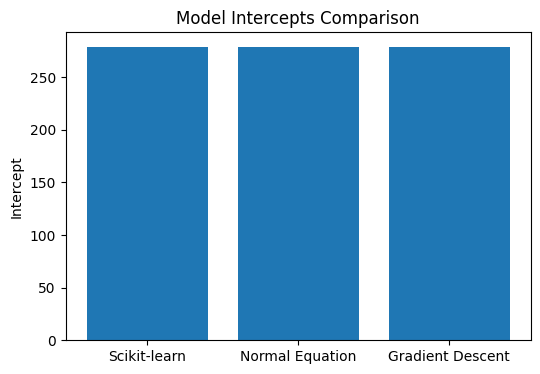

In [42]:
# Intercepts
plt.figure(figsize=(6, 4))
plt.bar(df_performance_metrics["Model"], df_performance_metrics["Intercept"])
plt.title("Model Intercepts Comparison")
plt.ylabel("Intercept")
plt.show()

coeffient comparison

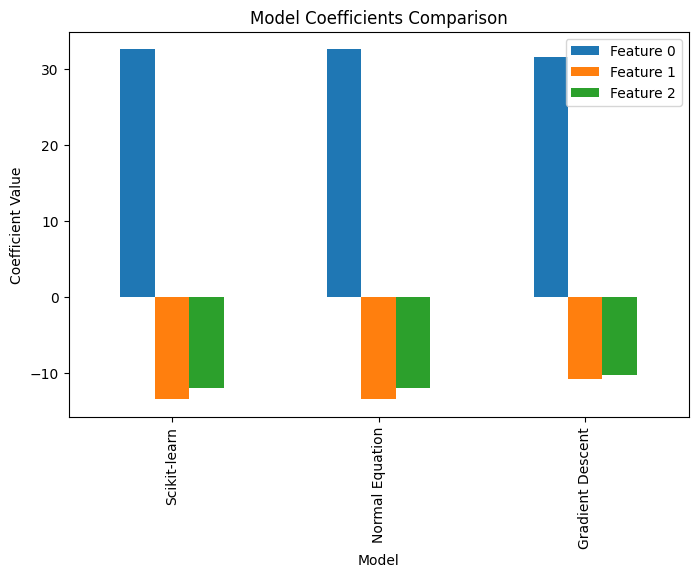

In [43]:
# Coefficients (stacked bar for multiple features)
coef_df = pd.DataFrame(
    df_performance_metrics["Coefficients"].tolist(),
    index=df_performance_metrics["Model"],
    columns=[f"Feature {i}" for i in range(X_scaled.shape[1])],
)
coef_df.plot(kind="bar", figsize=(8, 5))
plt.title("Model Coefficients Comparison")
plt.ylabel("Coefficient Value")
plt.show()

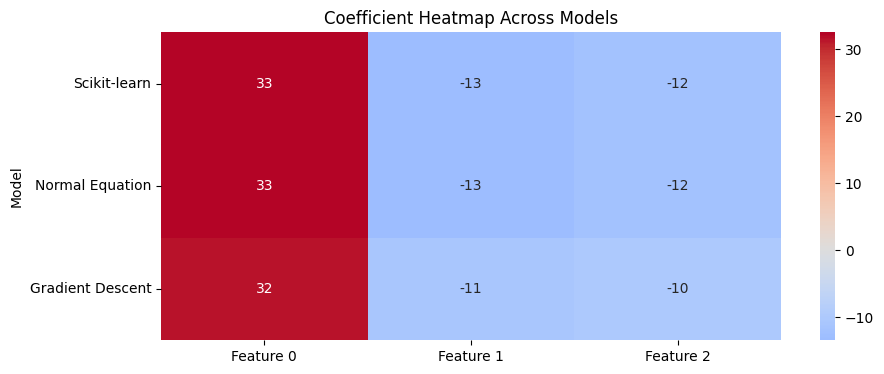

In [44]:
coef_df = pd.DataFrame(
    df_performance_metrics["Coefficients"].tolist(),
    index=df_performance_metrics["Model"],
    columns=[f"Feature {i}" for i in range(X_scaled.shape[1])],
)

plt.figure(figsize=(10, 4))
sns.heatmap(coef_df, annot=True, cmap="coolwarm", center=0)
plt.title("Coefficient Heatmap Across Models")
plt.show()

predictions vs true

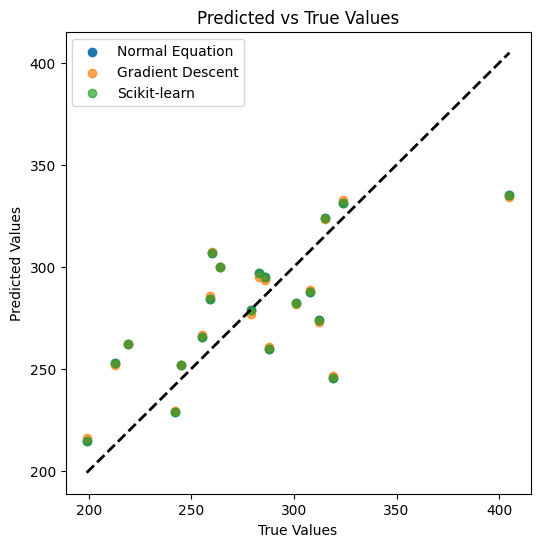

In [45]:
plt.figure(figsize=(6, 6))
plt.scatter(y, y_pred_ne, label="Normal Equation")
plt.scatter(y, y_pred_gd, label="Gradient Descent", alpha=0.7)
plt.scatter(y, y_pred_sklearn, label="Scikit-learn", alpha=0.7)
plt.plot([min(y), max(y)], [min(y), max(y)], "k--", lw=2)  # 45 degree line
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs True Values")
plt.legend()
plt.show()

error comparison

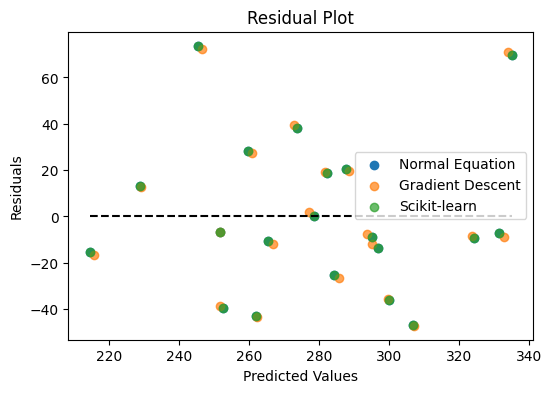

In [46]:
plt.figure(figsize=(6, 4))
plt.scatter(y_pred_ne, y - y_pred_ne, label="Normal Equation")
plt.scatter(y_pred_gd, y - y_pred_gd, label="Gradient Descent", alpha=0.7)
plt.scatter(y_pred_sklearn, y - y_pred_sklearn, label="Scikit-learn", alpha=0.7)
plt.hlines(y=0, xmin=min(y_pred_ne), xmax=max(y_pred_ne), colors="k", linestyles="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.legend()
plt.show()

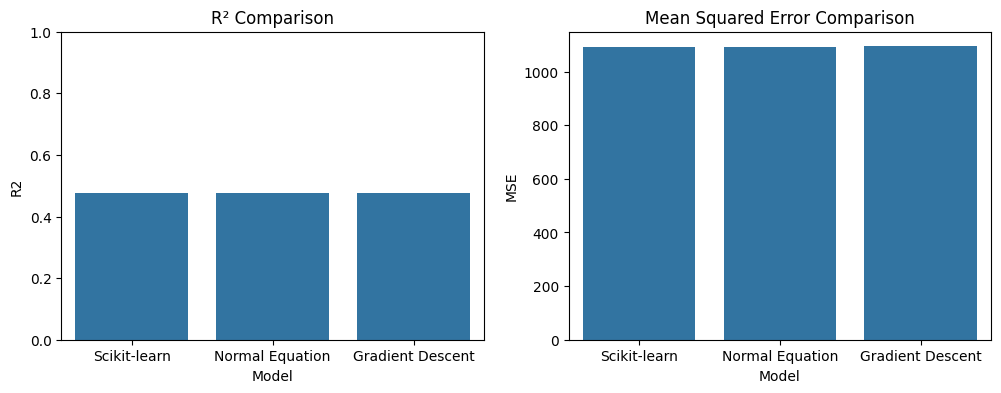

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.barplot(x="Model", y="R2", data=df_performance_metrics, ax=ax[0])
ax[0].set_title("R² Comparison")
ax[0].set_ylim(0, 1)

sns.barplot(x="Model", y="MSE", data=df_performance_metrics, ax=ax[1])
ax[1].set_title("Mean Squared Error Comparison")
plt.show()

fit time comparison

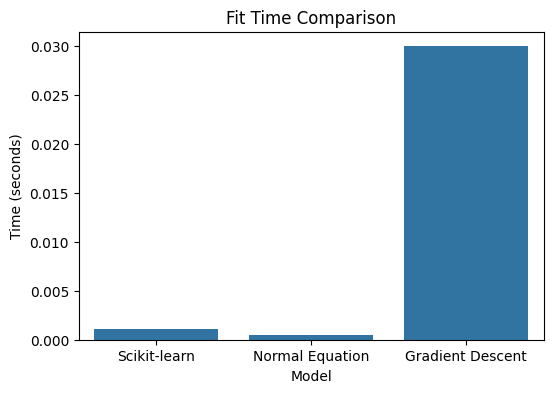

In [48]:
plt.figure(figsize=(6, 4))
sns.barplot(x="Model", y="Fit Time", data=df_performance_metrics)
plt.title("Fit Time Comparison")
plt.ylabel("Time (seconds)")
plt.show()

batch size comparison

In [49]:
batch_sizes = [1, 8, 16, 32, 64, 128, len(X)]  # len(X) = full batch (gradient descent)
batch_results = []

for bs in batch_sizes:
    gd = GradientDescent(
        fit_intercept=True,
        learning_rate=0.01,
        max_iter=1000,
        random_state=42,
        batch_size=bs,
    )
    start_time = time.time()
    gd.fit(X_scaled, y)
    fit_time = time.time() - start_time
    r2 = gd.score(X_scaled, y)
    mse = sum((yt - yp) ** 2 for yt, yp in zip(y, gd.predict(X_scaled))) / len(y)

    batch_results.append({"batch_size": bs, "R2": r2, "MSE": mse, "fit_time": fit_time})

In [54]:
print(batch_results)

[{'batch_size': 1, 'R2': np.float64(0.4770750458224535), 'MSE': np.float64(1092.8922372329052), 'fit_time': 0.1711881160736084}, {'batch_size': 8, 'R2': np.float64(0.4768356479632635), 'MSE': np.float64(1093.3925691826978), 'fit_time': 0.028416872024536133}, {'batch_size': 16, 'R2': np.float64(0.47575229601955527), 'MSE': np.float64(1095.6567314109702), 'fit_time': 0.022355079650878906}, {'batch_size': 32, 'R2': np.float64(0.4723661831705206), 'MSE': np.float64(1102.7335718209386), 'fit_time': 0.015639066696166992}, {'batch_size': 64, 'R2': np.float64(0.4723661831705206), 'MSE': np.float64(1102.7335718209386), 'fit_time': 0.01971912384033203}, {'batch_size': 128, 'R2': np.float64(0.4723661831705206), 'MSE': np.float64(1102.7335718209386), 'fit_time': 0.01566791534423828}, {'batch_size': 20, 'R2': np.float64(0.4723661831705206), 'MSE': np.float64(1102.7335718209386), 'fit_time': 0.015465021133422852}]


Accuracy (R² / MSE):
Smaller batch sizes (1–16) give higher R² and lower MSE.

Very small batch (1) gives the best R² (0.4771) but is slowest.
Training Time:

Larger batch sizes are much faster (0.015–0.02 s), but R² drops.

Trade-off:
Better accuracy = batch size 1–8
Better speed = batch size 32–64

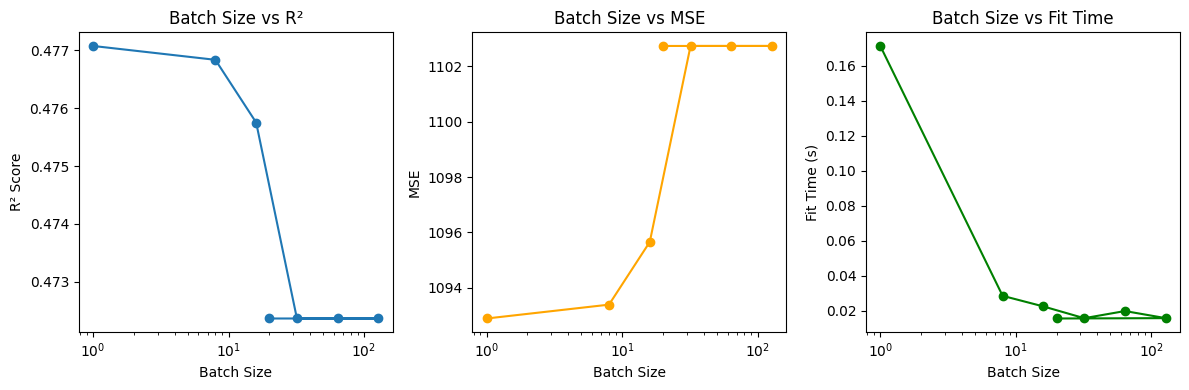

In [50]:
batch_sizes = [r["batch_size"] for r in batch_results]
r2_scores = [r["R2"] for r in batch_results]
mse_scores = [r["MSE"] for r in batch_results]
fit_times = [r["fit_time"] for r in batch_results]

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(batch_sizes, r2_scores, marker="o")
plt.xscale("log")
plt.xlabel("Batch Size")
plt.ylabel("R² Score")
plt.title("Batch Size vs R²")

plt.subplot(1, 3, 2)
plt.plot(batch_sizes, mse_scores, marker="o", color="orange")
plt.xscale("log")
plt.xlabel("Batch Size")
plt.ylabel("MSE")
plt.title("Batch Size vs MSE")

plt.subplot(1, 3, 3)
plt.plot(batch_sizes, fit_times, marker="o", color="green")
plt.xscale("log")
plt.xlabel("Batch Size")
plt.ylabel("Fit Time (s)")
plt.title("Batch Size vs Fit Time")

plt.tight_layout()
plt.show()

learning rate

cost history

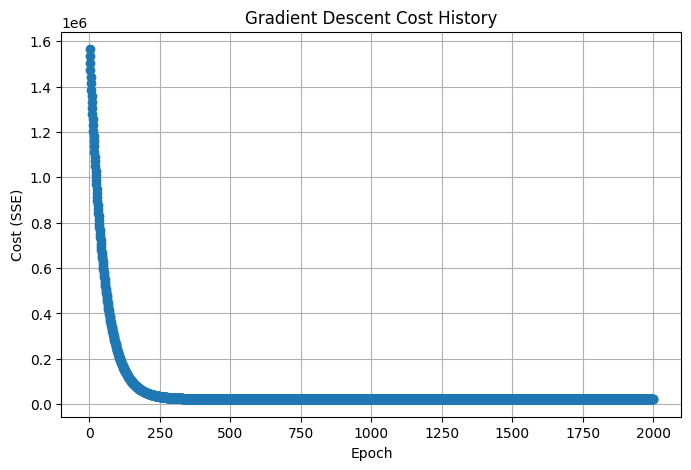

In [51]:
import matplotlib.pyplot as plt

# Assuming gd_lr is your fitted GradientDescent model
plt.figure(figsize=(8,5))
plt.plot(range(1, len(gd_lr.cost_history)+1), gd_lr.cost_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Cost (SSE)")
plt.title("Gradient Descent Cost History")
plt.grid(True)
plt.show()


###Summary of Findings
model performance:
normal equation and scikit-learn are almost identical in terms of predictions adn performance -- they both are faster and predict slightly bettern than gradient descent.